<h1><center>CMPE 462 - Quiz 4&5 <br>Implementing a Regression Tree<br>Due: May 5, 2020, 23:59</center></h1>


<h3> Gurkan Demir, 2015400177</h3>

# Introduction

Decision trees can learn rules to map features to both continous and discrete outputs. In this quiz, you will consider the continous case and implement a regression tree to predict house prices in Boston. You will also conduct small data analysis and evaluation procedures. This notebook will guide you through.

## (10 pts) Task 1: Dataset 

Run the cells below to load Boston house prices dataset using `scikit-learn`. You can find more detail on the dataset [here](https://scikit-learn.org/stable/datasets/index.html#boston-dataset). **Please use the train and test matrices we prepared for you :)**

In [1]:
import numpy as np
from sklearn.datasets import load_boston
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
boston = load_boston()
X_y = np.column_stack([boston['data'], boston['target']])
np.random.seed(1)
np.random.shuffle(X_y)
X, y = X_y[:,:-1], X_y[:,-1]
X_train, y_train = X[:400], y[:400]
X_test, y_test = X[400:], y[400:]
del X, y, X_y

**(10 pts)** Unlike the dataset in Project 1, Boston dataset is high-dimensional and we cannot observe the relations between all features and the output with a single scatter plot. What we can do is to visualize the correlations between both features and house prices using a heatmap. So, stack the features and the outputs in a single matrix and compute correlation between all pairs of columns. Visualize the correlation coefficient matrix as a heatmap, which is $(N+1)x(N+1)$, where $N$ is the number of features in Boston dataset. You can check out `corrcoef` and `heatmap` functions from `numpy` and `seaborn` libraries, respectively. You can use diverging color palette to emphasize both positive and negative correlations.

Do you observe strong correlations between any pair of features or certain features and house price? 

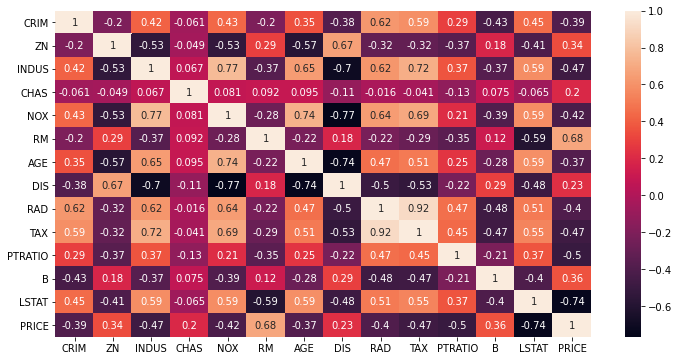

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

features = np.vstack([X_train.T, y_train])
ticks = np.append(boston.feature_names, "PRICE")

plt.figure(figsize=(12, 6))
ax=plt.subplot(111)

cm = np.corrcoef(features)
sns.heatmap(cm, annot=True, yticklabels=ticks, xticklabels=ticks)

corr_prices = abs(cm[-1,:-1])

* Correlation matrix is evaluated using only train set.
* For only train set, most correlated feature : LSTAT, least correlated feature : CHAS
* Each feature has distinct correlation with prices. Some features are positively correlated, whereas some of them are negatively correlated.

## (80 pts) Task 2: Regression Tree


**(15 pts)** Let us now build the regression tree. We start by implementing the splitting criteria which is used to decide the most discriminative features at each step. We stick to lecture notes and use $RSS$ which is computed as follows:

$$RSS =\sum_{\text {left }}\left(y_{i}-y_{L}^{*}\right)^{2}+\sum_{\text {right }}\left(y_{i}-y_{R}^{*}\right)^{2}$$

where $y_L^* and y_L^*$ are mean y-value of left and right nodes.

When you implement $RSS$, pick the most correlated and least correlated feature with the output prices according to previous step. Note that correlation can be both positive and negative! For both features, compute $RSS$ for every possible split threshold and plot thresholds versus RSS scores.

Do two features display different characteristics?

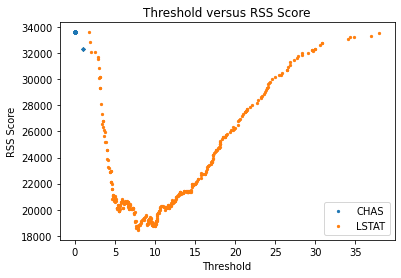

In [4]:
import warnings; warnings.simplefilter('ignore')

def rss_helper(t, row, target):
  left = []
  right = []

  for idx, elem in enumerate(row):
    left.append(target[idx]) if elem < t else right.append(target[idx])

  return sum((np.array(left) - np.mean(left))**2) + sum((np.array(right) - np.mean(right))**2)

def rss(index, data, target, plot):
  thresholds = data[:, index]
  x, y, min_val, thres = [], [], 999999, 0

  for t in thresholds:
    val = rss_helper(t, thresholds, target)
    x.append(t)
    y.append(val)
    if val < min_val:
      min_val = val
      thres = t
      
  if plot:
    plt.scatter(x, y, s=5, label = boston.feature_names[index])
    plt.xlabel('Threshold')
    plt.ylabel('RSS Score')
    plt.title('Threshold versus RSS Score')
    plt.legend(loc = 'best')

  return min_val, thres

def rss_func(datas, target, indexes = np.arange(13), plot = False):
  rss_val, thres, feature = 9999999, 0, 0
  for index in np.nditer(indexes):
    val, threshold = rss(index, datas, target, plot)
    if val < rss_val:
      rss_val = val
      thres = threshold
      feature = index

  a = np.hstack([datas, target.reshape((len(target), 1))])
  left, right = a[a[:,feature] < thres], a[a[:,feature] >= thres]
  return left[:, :-1], left[:, -1], right[:, :-1], right[:, -1], feature, thres

left, left_target, right, right_target, feature, thres = rss_func(X_train, y_train, indexes = np.array([corr_prices.argmin(), corr_prices.argmax()]), plot = True)

In most correlated feature **LSTAT**, RSS values are more discriminative. RSS values vary according to selected threshold. 

However in least correlated feature **CHAS**, it is much harder for us to dicriminate datas into two since values according to CHAS feature are almost same.

So we can conclude that choosing most correlated feature will split data in more better way.

**(45 pts)** Now implement the training procedure of a regression tree using $RSS$ as split criteria. Build a rule tree recursively by traversing all features and considering each split threshold to find the optimum split, at every node.

You are free to implement training procedure as a standalone function or part of a class, but in any case use maximum depth as the stopping condition.

In [0]:
class Node:
  def __init__(self, data, target, parent = None, level = 0):
    self.data = data
    self.target = target
    self.parent = parent
    self.value = np.mean(self.target) if len(self.target) > 0 else self.parent.value if self.parent is not None else 0
    self.level = level
    self.left = self.right = None
    self.feature = None
    self.threshold = None

class Tree:
  def __init__(self, datas, target, max_depth):
    self.root = Node(datas, target)
    self.max_depth = max_depth
    self.construct_tree()

  def construct_tree(self):
    dfs = []
    dfs.append(self.root)
    while len(dfs) > 0:
      curr_node = dfs.pop(0)
      if(curr_node.level == self.max_depth):
        break

      left, left_target, right, right_target, curr_node.feature, curr_node.threshold = rss_func(curr_node.data, curr_node.target)
      curr_node.left = Node(left, left_target, curr_node, curr_node.level + 1)
      curr_node.right = Node(right, right_target, curr_node, curr_node.level + 1)
      if len(left_target) > 0 and len(right_target) > 0:
        dfs.append(curr_node.left)
        dfs.append(curr_node.right)
  
  def predict(self, data):
    curr_node = self.root
    while True:
      if curr_node.feature is None:
        break

      test_value = data[curr_node.feature]
      curr_node = curr_node.left if test_value < curr_node.threshold else curr_node.right 

    return curr_node.value

**(15 pts)** Having implemented the regression tree, now write a procedure to predict test features. Given a sample, this procedure should follow the rules learned during the training to arrive at a leaf and predict the output as the mean output of the arrived leaf samples. 

If you have implemented a regression tree class, you can insert this procedure as a class function 

In [0]:
# Written as a function in a class above.

**(5 pts)** Train your model using a max depth of 3 and visualize the resulting tree. You can use an external tool such as draw.io or LaTeX for drawing. Annotate the nodes with split columns and thresholds. You can view the tree in this [link](https://scikit-learn.org/stable/modules/tree.html#tree) as an example. 

In this link, you can observe visualization of tree which has max depth 3.
https://drive.google.com/file/d/1tgaZzKnszLXCwbL2irR0gZ-ipppcnstL/view?usp=sharing

## **(10 pts)** Task 3: Evaluation

**(5 pts)** Now is time to pick the best maximum depth and observe your tree's performance! Implement a 5-fold cross validation procedure to experiment with maximum depths from 3 to 10. Report mean and standard deviation for each depth and pick the best one. For comparison you can use $R^2$, which is a metric frequently used to evaluate regression models. You can use `r2_score` function of `scikit-learn` and read more [here](https://scikit-learn.org/stable/modules/model_evaluation.html#r2-score).

In [0]:
from sklearn.metrics import r2_score
import warnings; warnings.simplefilter('ignore')

def calculate_r2_score(y_true, y_predicted):
  return r2_score(y_true, y_predicted)

def cross_validation(features, target, index):
  train = np.delete(features, slice(80 * (index), 80 * (index + 1)), 0)
  train_target = np.delete(target, slice(80 * (index), 80 * (index + 1)))
  validation = features[80 * (index) : 80 * (index + 1), :]
  validation_target = target[80 * (index) : 80 * (index + 1)]
  return train, train_target, validation, validation_target

r2_scores = np.zeros((5, 8))
for i in range(5):
  train_set, train_target, validation_set, validation_target = cross_validation(X_train, y_train, i)
  
  for depth in range(3, 11):
    tree = Tree(train_set, train_target, depth)
    
    predicted_labels = [tree.predict(feature) for feature in validation_set]
    score = calculate_r2_score(validation_target, predicted_labels)

    r2_scores[i][depth - 3] = score

print('Depth, Mean, Std')
for idx, (mean, std) in enumerate(zip(np.mean(r2_scores, axis = 0), np.std(r2_scores, axis = 0))):
  print('{}, {:.3f}, {:.3f}'.format(idx + 3, mean, std))

best_depth = np.mean(r2_scores, axis=0).argmax() + 3
print('Best max depth is ' + str(best_depth))


**(5 pts)** To conclude, train your tree one last time on the whole training data with the depth you picked in the previous section. Generate predictions on both training and test sets and report $R^2$ scores.

In [15]:
import warnings; warnings.simplefilter('ignore')

def evaluation(x_train, target_train, x_test, target_test, depth, train = True):
  print('Generating predictions for training set') if train else print('Generating predictions for test set')

  tree = Tree(x_train, target_train, depth)
  
  predicted_labels = [tree.predict(feature) for feature in x_test]
  score = calculate_r2_score(target_test, np.array(predicted_labels))
  
  print('R2 score is {:.3f}'.format(score))

  print('\n-----\n')

evaluation(X_train, y_train, X_train, y_train, best_depth)
evaluation(X_train, y_train, X_test, y_test, best_depth, False)


Generating predictions for training set
R2 score is 0.942

-----

Generating predictions for test set
R2 score is 0.854

-----

